# Application of Dynamic Mode Decomposition on Unigram Frequency Time-Series

## Arnold D. Kim, Maia Powell, Alex Quijano, Suzanne Sindi, and Ayme Tomson

*Department of Applied Mathematics, University of California, Merced*

In [24]:
import  time
print( 'Last updated: %s' %time.strftime('%d/%m/%Y') )

import numpy as np
import scipy as sc
import pandas as pd
from numpy.linalg import svd, eig # singular value decomposition and eigenvalues
from sklearn.metrics.pairwise import cosine_similarity as cs

import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.cm as cm

Last updated: 23/04/2019


### 1. Load Partitioned Unigram Frequency Time-series.

In [2]:
X = np.load('1gram-eng-partitioned.npz')['X'].item() 
# see data-downloading-and-partitioning.ipynb for details

### 2. Assign Variables to Matrices.

In [3]:
S = X['S'] # sentiment categories
Z_O = X['Z']['1900-1999'] # zscore matrix from 1900-1999
Z_A = X['Z']['1900-1949'] # zscore matrix from 1900-1949
Z_B = X['Z']['1950-1999'] # zscore matrix from 1950-1999

time_O = range(1900,1999+1) # O means 1900-1999
time_A = range(1900,1949+1) # A means 1900-1949
time_B = range(1950,1999+1) # B means 1950-1999

### 3. Sentiment Categories.

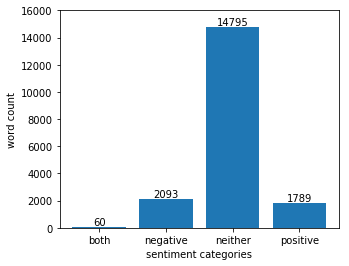

In [4]:
# plot sentiment categories and word counts
s_unique, s_counts = np.unique(list(S.values),return_counts=True)
fig, ax = plt.subplots(1,1,figsize=(5, 4))
ax.bar(s_unique,s_counts)
ax.set_xlabel('sentiment categories')
ax.set_ylabel('word count')
ax.set_xticklabels(s_unique,rotation=360)
ax.set_ylim(0,16000)
rects = ax.patches
labels = s_counts
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom')

In [5]:
# display example words
N_words = np.array(list(S.index[S['sentiment'] == 'negative']))
print('negative words: '+str(N_words))
P_words = np.array(list(S.index[S['sentiment'] == 'positive']))
print('positive words: '+str(P_words))
B_words = np.array(list(S.index[S['sentiment'] == 'both']))
print('both words: '+str(B_words))
I_words = np.array(list(S.index[S['sentiment'] == 'neither']))
print('neither words: '+str(I_words))

negative words: ['armaments' 'abolish' 'ache' ... 'warp' 'yell' 'yawning']
positive words: ['acknowledgment' 'agile' 'alive' ... 'zest' 'zeal' 'zealous']
both words: ['armed' 'abundance' 'buck' 'boisterous' 'boast' 'cunning' 'charmed'
 'confess' 'celebrity' 'diverse' 'dominate' 'dependent' 'endless'
 'enforce' 'escape' 'feeling' 'highest' 'humble' 'hail' 'immediately'
 'intervention' 'intense' 'influence' 'income' 'interminable' 'immovable'
 'lord' 'liberal' 'lace' 'maternal' 'mother' 'notoriety' 'outstanding'
 'outburst' 'petroleum' 'parade' 'prodigal' 'paraphrase' 'quote' 'remains'
 'revive' 'retirement' 'revolution' 'sterling' 'seclusion' 'spine'
 'sensual' 'supremacy' 'superstition' 'surround' 'spectacle' 'synonymous'
 'treat' 'teens' 'unexpected' 'uphill' 'unbridled' 'vote' 'weight'
 'yearning']
neither words: ['actor' 'anthony' 'anterior' ... 'zone' 'zur' 'zealously']


#### 3.1. Get Only Positive and Negative Submatrices.

In [89]:
S_sub = S['sentiment'][list(N_words)+list(P_words)+list(B_words)] # sentiment categories
Z_O_sub = Z_O.loc[:,list(N_words)+list(P_words)+list(B_words)] # zscore matrix from 1900-1999
Z_A_sub = Z_A.loc[:,list(N_words)+list(P_words)+list(B_words)] # zscore matrix from 1900-1949
Z_B_sub = Z_B.loc[:,list(N_words)+list(P_words)+list(B_words)] # zscore matrix from 1950-1999

#### 3.2. Explained Variance Parameter (set for PCA and DMD).

In [70]:
p_limit = 0.75

### 4. Principal Component Analysis (PCA).

In [98]:
# principal component analysis via singular value decomposition
def pca(X):
    # compute singlar value decomposition
    U, S, Vh = svd(X)
    # compute principal components
    sigma_full = np.zeros(X.shape,dtype=float)
    np.fill_diagonal(sigma_full,S)
    PC = np.matmul(U,sigma_full)
    # compute explianed variance ratio
    evr = np.divide(S,np.sum(S))
    # return values
    return PC, evr, U, S, Vh

# extract number of singular values that explained p% of variance
def get_k(ev,variance_limit=p_limit):
    cr = [ev[0]] # cumulative ratio
    svi = 0 # singular value index
    for i in range(1,len(ev)):
        cr.append(cr[i-1]+ev[i])
        if cr[i-1] <= variance_limit:
            svi = i
    return svi, cr

def pca_analysis(X,year_range,p=p_limit):
    # apply PCA
    components_PCA, evr_PCA, U_PCA, S_PCA, Vh_PCA = pca(np.transpose(X.values))
    print('principal components size (all): '+str(components_PCA.shape))

    # get variance limit
    svi_PCA, cr_PCA = get_k(evr_PCA)

    # reduced principal components
    components_reduced_PCA = components_PCA[:,0:svi_PCA]
    Vh_reduced_PCA = Vh_PCA[0:svi_PCA,:]
    print('principal components size (reduced): '+str(components_reduced_PCA.shape))

    # plot singular values and p% variance explained
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # singular values
    ax[0].plot(S_PCA,'.',
             label='singular values')
    ax[0].axvline(svi_PCA,linestyle='--',color='red',
                label=str(round(p*100,2))+'% variance explained \n ('+str(svi_PCA+1)+' singular values)')
    ax[0].set_xlabel('index')
    ax[0].set_ylabel('singular value')
    ax[0].set_title(year_range)
    ax[0].legend(loc=0)
    # cumulative explained variance ratio
    ax[1].plot(cr_PCA,'.',
             label='cumulative ratio')
    ax[1].axvline(svi_PCA,linestyle='--',color='red',
                label=str(round(p*100,2))+'% variance explained \n ('+str(svi_PCA+1)+' singular values)')
    ax[1].set_xlabel('index')
    ax[1].set_ylabel('cumulative ratio')
    ax[1].set_title(year_range)
    ax[1].legend(loc=0)
    plt.show()
    
    # reconstruction using PCA
    X_reconstructed = np.transpose(np.matmul(components_reduced_PCA,Vh_reduced_PCA))
    X_reconstructed = pd.DataFrame(X_reconstructed,index=X.index,columns=X.columns)

    # residuals
    R_O = X-X_reconstructed
    R_O = pd.DataFrame(R_O,index=X.index,columns=X.columns)
    R_norm = np.linalg.norm(R_O,axis=0) # root mean square error for each word/column
    R_norm = pd.DataFrame(R_norm,index=X.columns,columns=['RMSE'])

    # plot residuals
    plt.hist(R_norm['RMSE'],bins=100,density=True)
    plt.xlabel('RMSE')
    plt.ylabel('density')
    plt.title(year_range)
    plt.show()
    
    # plot time-series reconstructions
    R_norm_sorted = R_norm.sort_values(by=['RMSE'])
    R_norm_sorted = list(R_norm_sorted.index)

    n = 3
    bottom = R_norm_sorted[0:n]
    top = list(reversed(R_norm_sorted))[0:n]

    cmap = cm.get_cmap('tab10')
    bottom_color = {k:cmap(i) for i, k in enumerate(bottom)}
    top_color = {k:cmap(i) for i, k in enumerate(top)}

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    for i in top:
        ax[0].plot(X[i],'.',markersize=10,markeredgecolor='k',alpha=0.75,
                 color=top_color[i],label=i+' (data)')
        ax[0].plot(X_reconstructed[i],':',linewidth=3,
                 color=top_color[i],label=i+' (PCA)')
    ax[0].legend(bbox_to_anchor=(1,1),loc='upper left',ncol=1)
    ax[0].set_xlabel('year')
    ax[0].set_ylabel('zscore')
    ax[0].set_title(year_range+' PCA reconstruction (top RMSE examples)')
    for i in bottom:
        ax[1].plot(X[i],'.',markersize=10,markeredgecolor='k',alpha=0.75,
                 color=bottom_color[i],label=i+' (data)')
        ax[1].plot(X_reconstructed[i],':',linewidth=3,
                 color=bottom_color[i],label=i+' (PCA)')
    ax[1].legend(bbox_to_anchor=(1,1),loc='upper left',ncol=1)
    ax[1].set_xlabel('year')
    ax[1].set_ylabel('zscore')
    ax[1].set_title(year_range+' PCA reconstruction (bottom RMSE examples)')
    plt.tight_layout()
    plt.show()
    

#### 4.1. 1900-1999 Time-Series Reconstruction using PCA.

principal components size (all): (3942, 100)
principal components size (reduced): (3942, 47)


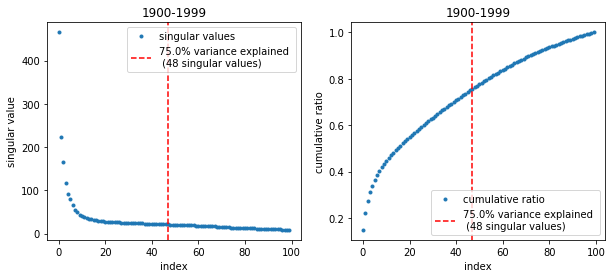

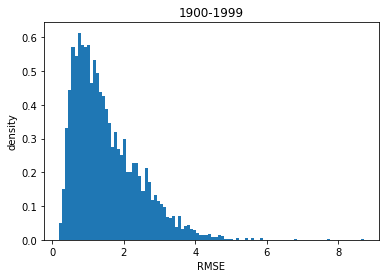

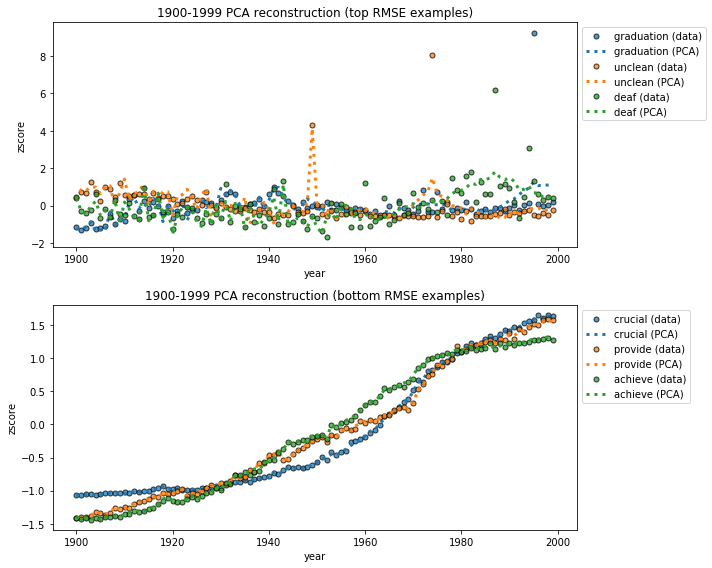

In [99]:
year_range = '1900-1999'
X = Z_O_sub

pca_analysis(X,year_range)

#### 4.2. 1900-1949 Time-Series Reconstruction using PCA.

principal components size (all): (3942, 50)
principal components size (reduced): (3942, 28)


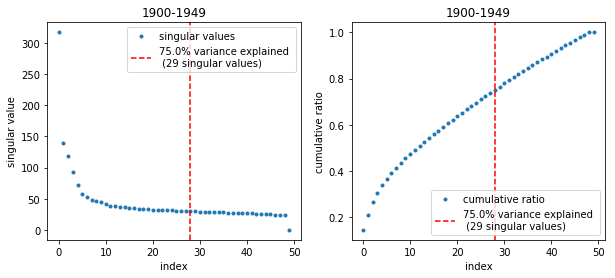

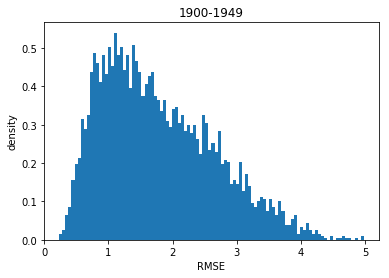

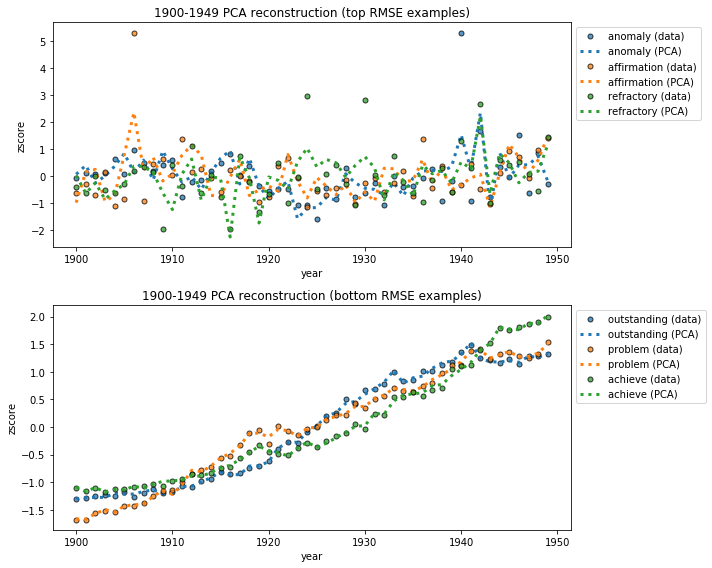

In [100]:
year_range = '1900-1949'
X = Z_A_sub

pca_analysis(X,year_range)

#### 4.3. 1950-1999 Time-Series Reconstruction using PCA.

principal components size (all): (3942, 50)
principal components size (reduced): (3942, 24)


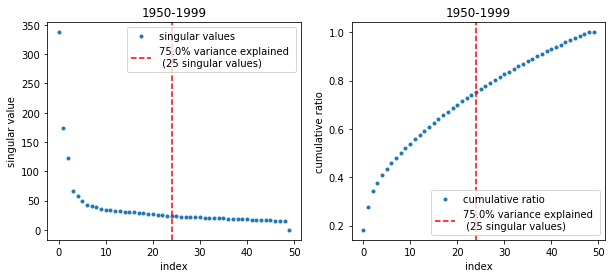

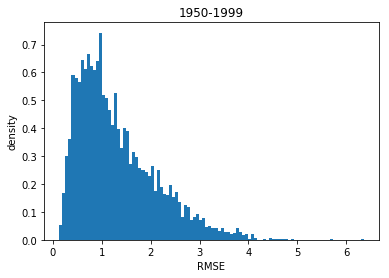

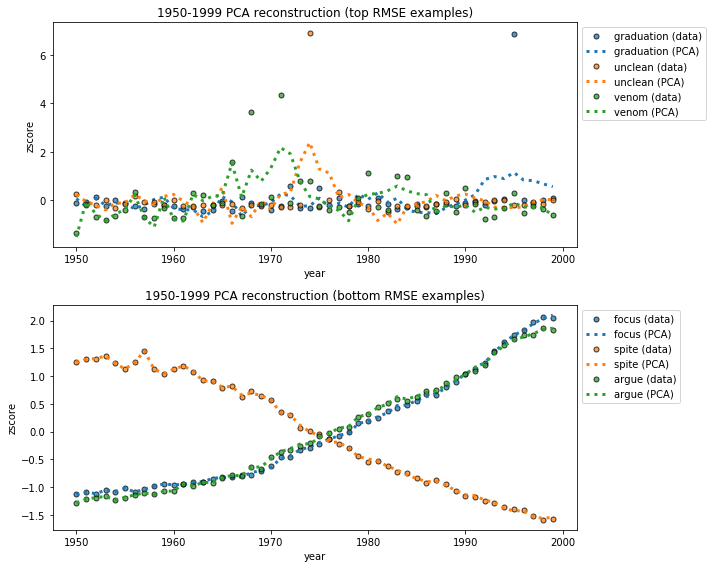

In [101]:
year_range = '1950-1999'
X = Z_B_sub

pca_analysis(X,year_range)

### 5. Dynamic Mode Decomposition (DMD).

In [106]:
# dynamic mode decomposition via singular value decomposition
def pre_dmd(X):
    # extract training data
    Ntrain = X.shape[1]-1
    Y_0 = X[:,list(range(0,Ntrain))]
    Y_1 = X[:,list(range(1,Ntrain+1))]
    # compute singular value decomposition
    U, S, Vh = svd(Y_0)
    # compute explianed variance ratio
    evr = np.divide(S,np.sum(S))
    # return values
    return Y_0, Y_1, U, S, Vh, evr

# extract number of singular values that explained p% of variance
def get_k(ev,variance_limit=p_limit):
    cr = [ev[0]] # cumulative ratio
    svi = 0 # singular value index
    for i in range(1,len(ev)):
        cr.append(cr[i-1]+ev[i])
        if cr[i-1] <= variance_limit:
            svi = i
    return svi, cr
    
def dmd(X):
    # pre dmd
    Y_0, Y_1, U, S, Vh, evr = pre_dmd(X)
    # percent variance
    svi, cr = get_k(evr)
    # compute pseudoinverse of the singular values
    Sinv = np.zeros(np.transpose(Y_0).shape,dtype=float)
    for j, i in enumerate(S[0:svi]):
        Sinv[j,j]=1/i
    # compute DMD matrix
    A = np.matmul( Y_1, np.matmul( np.matmul( Vh.conj().T, Sinv ), U.conj().T ) )
    # return values
    return A, Y_0, S, cr, svi

def dmd_analysis(X, year_range,p=p_limit):
    A, Y_0, S_DMD, cr_DMD, svi_DMD = dmd(np.transpose(X.values))
        
    # plot singular values and p% variance explained
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # singular values
    ax[0].plot(S_DMD,'.',
             label='singular values')
    ax[0].axvline(svi_DMD,linestyle='--',color='red',
                label=str(round(p*100,2))+'% variance explained \n ('+str(svi_DMD+1)+' singular values)')
    ax[0].set_xlabel('index')
    ax[0].set_ylabel('singular value')
    ax[0].set_title(year_range)
    ax[0].legend(loc=0)
    # cumulative explained variance ratio
    ax[1].plot(cr_DMD,'.',
             label='cumulative ratio')
    ax[1].axvline(svi_DMD,linestyle='--',color='red',
                label=str(round(p*100,2))+'% variance explained \n ('+str(svi_DMD+1)+' singular values)')
    ax[1].set_xlabel('index')
    ax[1].set_ylabel('cumulative ratio')
    ax[1].set_title(year_range)
    ax[1].legend(loc=0)
    plt.show()
    
    # plot eigenvalues of the DMD matrix A
    A_eigenvals, A_eigenvects = eig(A)
    unit_circ = plt.Circle((0,0),radius=1,edgecolor='k',facecolor='gray',alpha=0.25)
    fig, ax = plt.subplots(1,1,figsize=(5,4))
    for ii, i in enumerate(A_eigenvals):
        modulus = round(abs(i),2)
        if modulus < 1:
            ax.plot(i.real,i.imag,'.',color='k')
        elif modulus >= 1:
            ax.plot(i.real,i.imag,'.',color='r')
    ax.add_patch(unit_circ)
    ax.set_xlabel('real part')
    ax.set_ylabel('imaginary part')
    ax.set_title('Eigenvalues of A')
    ax.axis('square')
    plt.tight_layout()
    plt.show()
    
    # reconstruction using DMD
    Y_1_reconstructed = np.transpose(np.matmul( A, Y_0 ))
    X_reconstructed = np.zeros(X.shape,dtype=float)
    X_reconstructed[0,:] = Y_0[:,0]
    X_reconstructed[1:,:] = Y_1_reconstructed
    X_reconstructed = pd.DataFrame(X_reconstructed,index=X.index,columns=X.columns)

    # residuals
    R_O = X-X_reconstructed
    R_O = pd.DataFrame(R_O,index=X.index,columns=X.columns)
    R_norm = np.linalg.norm(R_O,axis=0) # root mean square error for each word/column
    R_norm = pd.DataFrame(R_norm,index=X.columns,columns=['RMSE'])

    # plot residuals
    plt.hist(R_norm['RMSE'],bins=100,density=True)
    plt.xlabel('RMSE')
    plt.ylabel('density')
    plt.title(year_range)
    plt.show()
    
    # plot time-series reconstructions
    R_norm_sorted = R_norm.sort_values(by=['RMSE'])
    R_norm_sorted = list(R_norm_sorted.index)

    n = 3
    bottom = R_norm_sorted[0:n]
    top = list(reversed(R_norm_sorted))[0:n]

    cmap = cm.get_cmap('tab10')
    bottom_color = {k:cmap(i) for i, k in enumerate(bottom)}
    top_color = {k:cmap(i) for i, k in enumerate(top)}

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    for i in top:
        ax[0].plot(X[i],'.',markersize=10,markeredgecolor='k',alpha=0.75,
                 color=top_color[i],label=i+' (data)')
        ax[0].plot(X_reconstructed[i],':',linewidth=3,
                 color=top_color[i],label=i+' (DMD)')
    ax[0].legend(bbox_to_anchor=(1,1),loc='upper left',ncol=1)
    ax[0].set_xlabel('year')
    ax[0].set_ylabel('zscore')
    ax[0].set_title(year_range+' DMD reconstruction (top RMSE examples)')
    for i in bottom:
        ax[1].plot(X[i],'.',markersize=10,markeredgecolor='k',alpha=0.75,
                 color=bottom_color[i],label=i+' (data)')
        ax[1].plot(X_reconstructed[i],':',linewidth=3,
                 color=bottom_color[i],label=i+' (DMD)')
    ax[1].legend(bbox_to_anchor=(1,1),loc='upper left',ncol=1)
    ax[1].set_xlabel('year')
    ax[1].set_ylabel('zscore')
    ax[1].set_title(year_range+' DMD reconstruction (bottom RMSE examples)')
    plt.tight_layout()
    plt.show()

#### 5.1. 1900-1999 Time-Series Reconstruction using DMD.

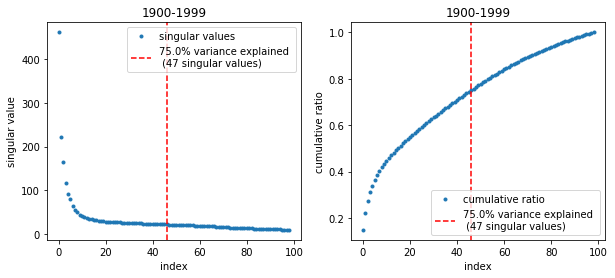

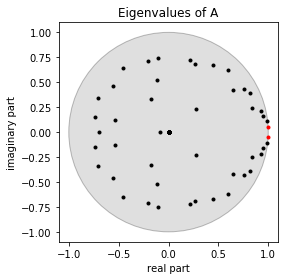

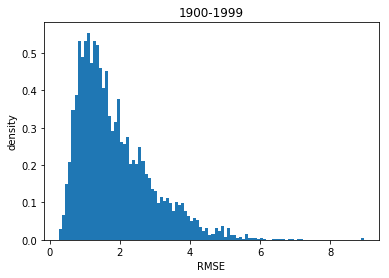

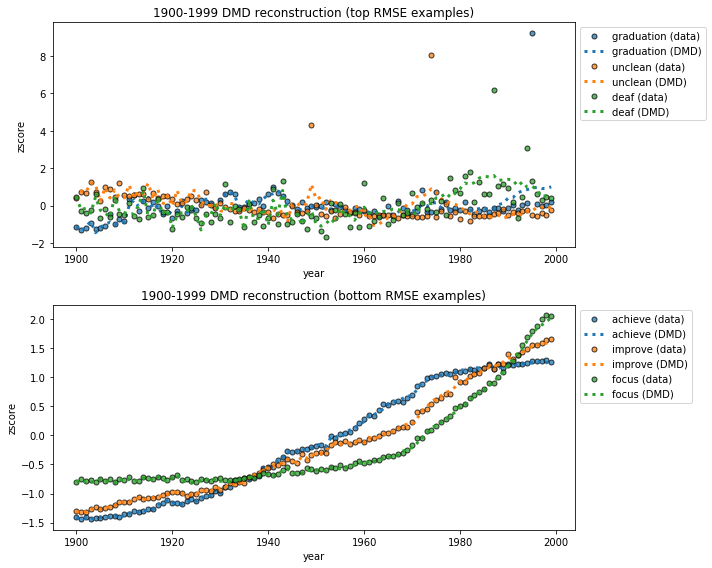

In [107]:
time_range = '1900-1999'
X = Z_O_sub

dmd_analysis(X,time_range)

#### 5.2. 1900-1949 Time-Series Reconstruction using DMD.

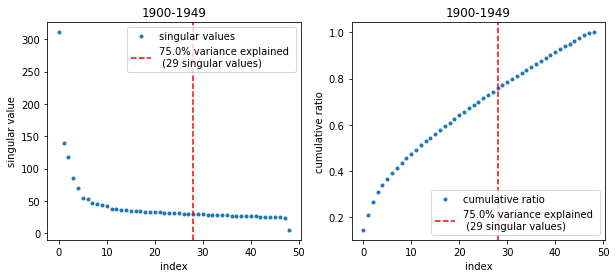

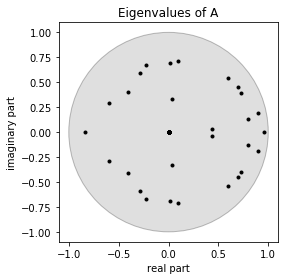

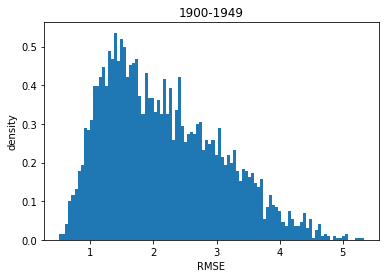

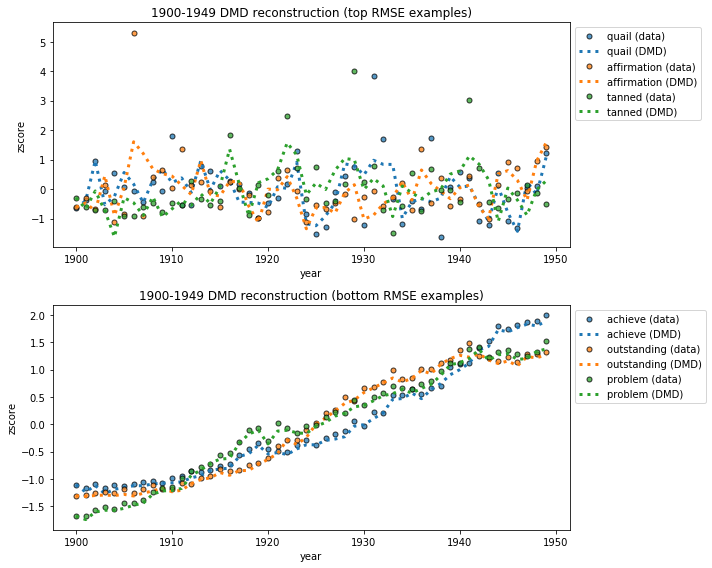

In [108]:
time_range = '1900-1949'
X = Z_A_sub

dmd_analysis(X,time_range)

#### 5.3. 1950-1999 Time-series Reconstruction using DMD.

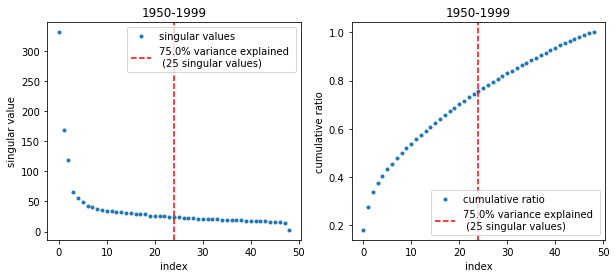

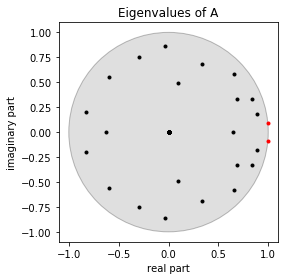

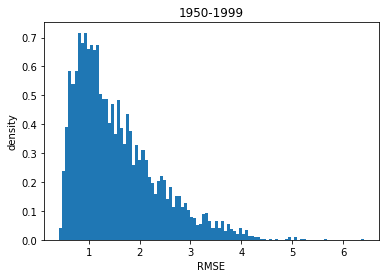

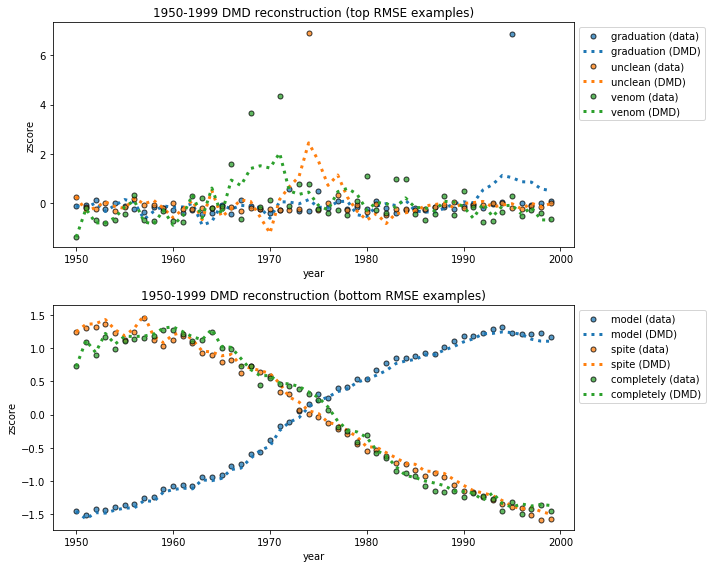

In [109]:
time_range = '1950-1999'
X = Z_B_sub

dmd_analysis(X,time_range)